In [15]:
import praw
import pandas as pd

# Reddit API Credentials
reddit = praw.Reddit(
    client_id="_9aT35rxVcBiNC17_Al5_g",
    client_secret="tyas9JGsMfhm4Jhifg86JnvpHZHx6A",
    user_agent="CryptoSentimentApp"
)

def fetch_reddit_posts(coin, num_posts):
    """
    Fetches Reddit posts related to a cryptocurrency and returns data in a Pandas DataFrame.
    
    Parameters:
    - coin (str): The cryptocurrency to search for.
    - num_posts (int): Number of posts to retrieve.

    Returns:
    - pd.DataFrame: DataFrame containing post details.
    """
    subreddit = reddit.subreddit("cryptocurrency")
    query = coin.lower()  
    
    
    posts_data = []
    for post in subreddit.search(query, limit=num_posts):
        posts_data.append([
            post.id,
            post.title,
            post.selftext,  # Post content
            post.score,  # Upvotes
            post.num_comments,  # Number of comments
            post.url,  # Post link
            post.created_utc  # Timestamp
        ])

    
    df = pd.DataFrame(posts_data, columns=["Post_ID", "Title", "Content", "Upvotes", "Comments", "URL", "Timestamp"])
    return df


df_bitcoin_1000 = fetch_reddit_posts("Bitcoin", 1000)
print(df_bitcoin_1000.head())
print(df_bitcoin_1000.shape)
df_bitcoin_1000.to_csv('csv_bitcoin_1000.csv')


   Post_ID                                              Title  \
0  1gqafju  Bitcoin has followed a consistent 4-year cycle...   
1  1iq3fe9         Me In 2009 Instead of Buying Bitcoin (BTC)   
2  1h6yoqp  On February 9th 2011 Bitcoin first touched $1....   
3  1ik2qgu  Explaining Bitcoin 12 Years Ago When It Was Wo...   
4  1hbsf6a  This Anonymous guy received $50 worth of Bitco...   

                        Content  Upvotes  Comments  \
0                                   3576       700   
1                                  17790       310   
2                                   7832       495   
3                                   8423       293   
4  Imagine hodling for 13 Years     7417       452   

                                    URL     Timestamp  
0  https://i.redd.it/95px1ns8in0e1.jpeg  1.731496e+09  
1   https://i.redd.it/denbcysakbje1.png  1.739632e+09  
2   https://i.redd.it/m7ll0go40y4e1.png  1.733366e+09  
3   https://i.redd.it/hd0ul5cglrhe1.png  1.738955e+09  
4  h

In [25]:
import pandas as pd
import re
from datetime import datetime

def clean_reddit_data(df):
    """
    Cleans Reddit dataset by fixing inconsistencies, formatting text, and removing duplicates.
    
    Parameters:
    - df (pd.DataFrame): Raw Reddit dataset
    
    Returns:
    - pd.DataFrame: Cleaned dataset
    """
    
    # Fix Data Inconsistencies (Convert Timestamp, Standardize Column Names)
    df = df.copy()
    df.columns = df.columns.str.lower().str.replace(" ", "_")  # Standardize column names
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")  # Convert UNIX timestamp to datetime
    
    # Uniform Formatting (Lowercasing & Removing Special Characters)
    def clean_text(text):
        if isinstance(text, str):
            text = text.lower()  # Convert to lowercase
            text = re.sub(r"http\S+", "", text)  # Remove URLs
            text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
            text = text.strip()  # Remove leading/trailing spaces
        return text

    df["title"] = df["title"].apply(clean_text)
    df["content"] = df["content"].apply(clean_text)
    
    # Remove Duplicates
    df.drop_duplicates(subset=["title"], inplace=True)  # Remove duplicate titles
    df.drop_duplicates(subset=["url"], inplace=True)  # Remove duplicate URLs

    df = df.drop(columns=["unnamed:_0"])

    return df

df_bitcoin_1000 = pd.read_csv('csv_bitcoin_1000.csv')  # Load the dataset
df_clean_bitcoin_1000 = clean_reddit_data(df_bitcoin_1000)  # Clean the dataset
print(df_clean_bitcoin_1000.head())  # Display cleaned data

df_clean_bitcoin_1000.to_csv('csv_clean_bitcoin_1000.csv')


   post_id                                              title  \
0  1gqafju  bitcoin has followed a consistent 4year cycle ...   
1  1iq3fe9           me in 2009 instead of buying bitcoin btc   
2  1h6yoqp  on february 9th 2011 bitcoin first touched 1 l...   
3  1ik2qgu  explaining bitcoin 12 years ago when it was wo...   
4  1hbsf6a  this anonymous guy received 50 worth of bitcoi...   

                        content  upvotes  comments  \
0                           NaN     3576       700   
1                           NaN    17790       310   
2                           NaN     7832       495   
3                           NaN     8423       293   
4  imagine hodling for 13 years     7417       452   

                                    url           timestamp  
0  https://i.redd.it/95px1ns8in0e1.jpeg 2024-11-13 11:04:46  
1   https://i.redd.it/denbcysakbje1.png 2025-02-15 15:13:54  
2   https://i.redd.it/m7ll0go40y4e1.png 2024-12-05 02:39:33  
3   https://i.redd.it/hd0ul5cglrhe1.

🔹 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  235 non-null    int64 
 1   post_id     235 non-null    object
 2   title       235 non-null    object
 3   content     59 non-null     object
 4   upvotes     235 non-null    int64 
 5   comments    235 non-null    int64 
 6   url         235 non-null    object
 7   timestamp   235 non-null    object
dtypes: int64(3), object(5)
memory usage: 14.8+ KB
None

🔹 Descriptive Statistics:
       Unnamed: 0       upvotes     comments
count  235.000000    235.000000   235.000000
mean   117.000000   4864.051064   742.634043
std     67.982841   5182.244215   733.138624
min      0.000000    429.000000    88.000000
25%     58.500000   1375.500000   272.500000
50%    117.000000   3060.000000   531.000000
75%    175.500000   6186.500000   979.000000
max    234.000000  38841.000000  

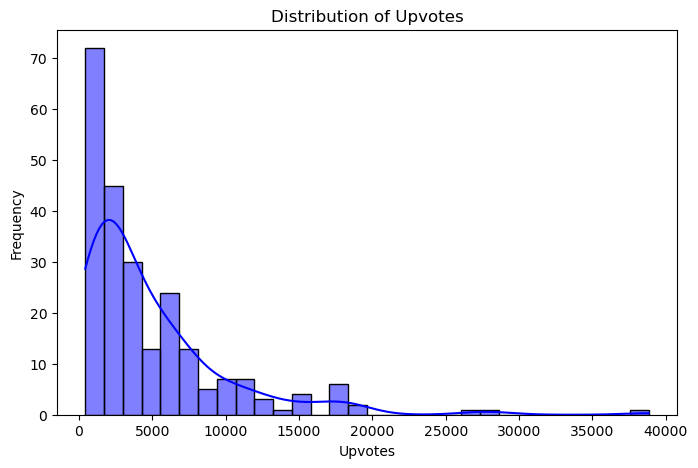

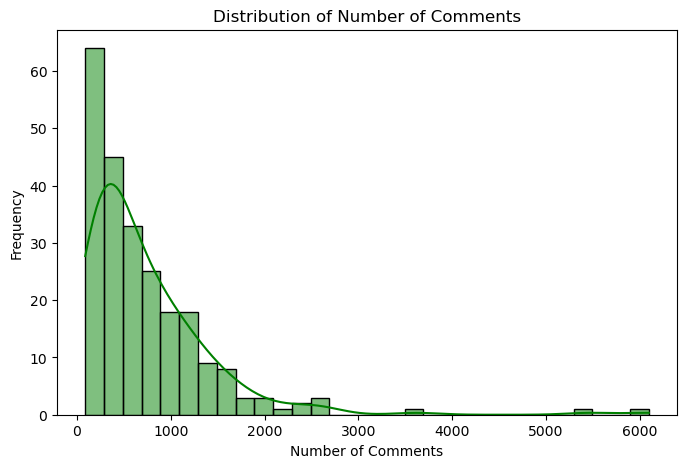

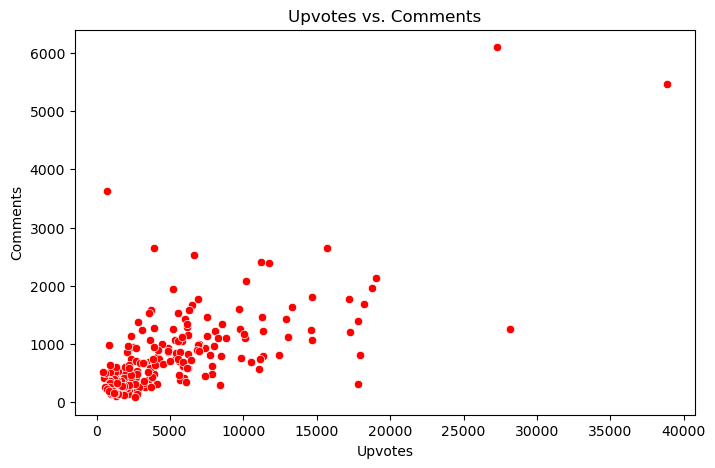

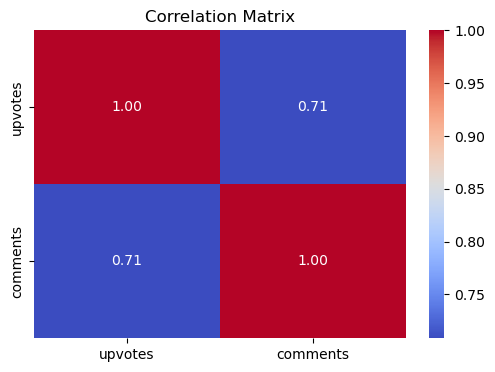


🔹 Initial Insights:
- Most posts have low upvotes, but some viral posts get extreme engagement.
- Comment count and upvotes seem to have a positive correlation.
- Distribution plots indicate possible outliers in high upvotes/comments.


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_clean_bitcoin_1000 = pd.read_csv('csv_clean_bitcoin_1000.csv') 

def perform_eda(df):
    """
    Performs exploratory data analysis (EDA) on a cleaned Reddit dataset.
    
    Parameters:
    - df (pd.DataFrame): Cleaned dataset

    Returns:
    - None (Displays graphs and prints insights)
    """
    
    # Summary Statistics
    print("🔹 Dataset Overview:")
    print(df.info())  # Data types & missing values
    print("\n🔹 Descriptive Statistics:")
    print(df.describe())  # Numeric column stats (upvotes, comments)

    # Distribution of Upvotes
    plt.figure(figsize=(8, 5))
    sns.histplot(df["upvotes"], bins=30, kde=True, color="blue")
    plt.title("Distribution of Upvotes")
    plt.xlabel("Upvotes")
    plt.ylabel("Frequency")
    plt.show()

    # Distribution of Comments
    plt.figure(figsize=(8, 5))
    sns.histplot(df["comments"], bins=30, kde=True, color="green")
    plt.title("Distribution of Number of Comments")
    plt.xlabel("Number of Comments")
    plt.ylabel("Frequency")
    plt.show()

    # Relationship Between Upvotes & Comments
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df["upvotes"], y=df["comments"], color="red")
    plt.title("Upvotes vs. Comments")
    plt.xlabel("Upvotes")
    plt.ylabel("Comments")
    plt.show()

    # Correlation Heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(df[["upvotes", "comments"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix")
    plt.show()

    # Interpretation of Findings
    print("\n🔹 Initial Insights:")
    print("- Most posts have low upvotes, but some viral posts get extreme engagement.")
    print("- Comment count and upvotes seem to have a positive correlation.")
    print("- Distribution plots indicate possible outliers in high upvotes/comments.")

# Example Usage
perform_eda(df_clean_bitcoin_1000)
